# Modéle Global de prédiction des nouveuax cas de COVID-19 (Tous les pays)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## Chargement des données 

In [50]:
df = pd.read_csv("../dataset/clean_covid19_data_v2.csv", parse_dates=["date"])

# Tri par pays et date
df = df.sort_values(["country", "date"])

# afficher les premières lignes du DataFrame
print(df.head())

      iso_code continent      country       date  total_cases  new_cases  \
12879      AFG      Asia  Afghanistan 2020-03-29           91         67   
6424       AFG      Asia  Afghanistan 2020-04-05          274        183   
12880      AFG      Asia  Afghanistan 2020-04-12          521        247   
0          AFG      Asia  Afghanistan 2020-04-19          908        387   
6425       AFG      Asia  Afghanistan 2020-04-26         1330        422   

       total_deaths  new_deaths  total_tests  positive_rate  ...  \
12879             2           2       518446           0.21  ...   
6424              5           3      6814263           0.05  ...   
12880            15          10      1716584           0.18  ...   
0                30          15      8796131           0.19  ...   
6425             43          13      7514673           0.30  ...   

       hospital_beds_per_thousand  extreme_poverty  new_vaccinations_smoothed  \
12879                         0.5            0.334   

## Feature Engineering
## Création de nouvelles colonnes pour les caractéristiques temporelles

In [ ]:
# Regroupement par pays
grouped = df.groupby("country")

def add_features(group):
    group = group.copy()
    group["new_cases_lag1"] = group["new_cases"].shift(1)
    group["new_cases_lag7"] = group["new_cases"].shift(7)
    group["new_cases_ma7"] = group["new_cases"].rolling(window=7).mean()
    group["growth_rate"] = group["new_cases"] / (group["new_cases_lag1"] + 1e-5)
    # Création des colonnes manquantes si elles n'existent pas
    if "vaccinated_rate" not in group.columns:
        group["vaccinated_rate"] = group["people_vaccinated"] / (group["population"] + 1e-5)
    if "boosted_rate" not in group.columns:
        group["boosted_rate"] = group["total_boosters"] / (group["population"] + 1e-5)
    return group

# NOTE : J'ai utilisé 1e-5 pour éviter la division par zéro dans les taux de vaccination et de rappel.

# Appliquer à chaque pays
df = grouped.apply(add_features).reset_index(drop=True)

# Suppression des lignes avec valeurs NaN (dues aux shifts)
df = df.dropna()

# Afficher les premières lignes du DataFrame après ajout des features
print(df.head())

   iso_code continent      country       date  total_cases  new_cases  \
7       AFG      Asia  Afghanistan 2020-05-17         6053       2490   
8       AFG      Asia  Afghanistan 2020-05-24         9866       3813   
9       AFG      Asia  Afghanistan 2020-05-31        14443       4577   
10      AFG      Asia  Afghanistan 2020-06-07        19551       5108   
11      AFG      Asia  Afghanistan 2020-06-14        24102       4551   

    total_deaths  new_deaths  total_tests  positive_rate  ...  \
7            153          48      1922639           0.23  ...   
8            211          58      4476176           0.15  ...   
9            248          37      9649140           0.23  ...   
10           327          79      1383022           0.26  ...   
11           451         124      5729980           0.27  ...   

    total_cases_per_million  new_cases_per_million  total_deaths_per_million  \
7                   149.166                 61.362                     3.770   
8         

C:\Users\wamba\AppData\Local\Temp\ipykernel_6936\3584634287.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = grouped.apply(add_features).reset_index(drop=True)


## Préparation des données pour l'entraînement

In [52]:
country_columns = [col for col in df.columns if col.startswith("country_")]
features = [
    "new_cases_lag1", "new_cases_lag7", "new_cases_ma7", "growth_rate",
    "reproduction_rate", "positive_rate", "icu_patients", "hosp_patients",
    "stringency_index", "vaccinated_rate", "boosted_rate"
]
target = "new_cases"

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

## Entraînement du modèle

In [53]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Évaluation du modèle global

In [56]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R² : {r2:.2f}")

MAE : 6840.29
RMSE : 88702.77
R² : 0.83


## Courbe réelle vs prédite (exemple sur un pays)

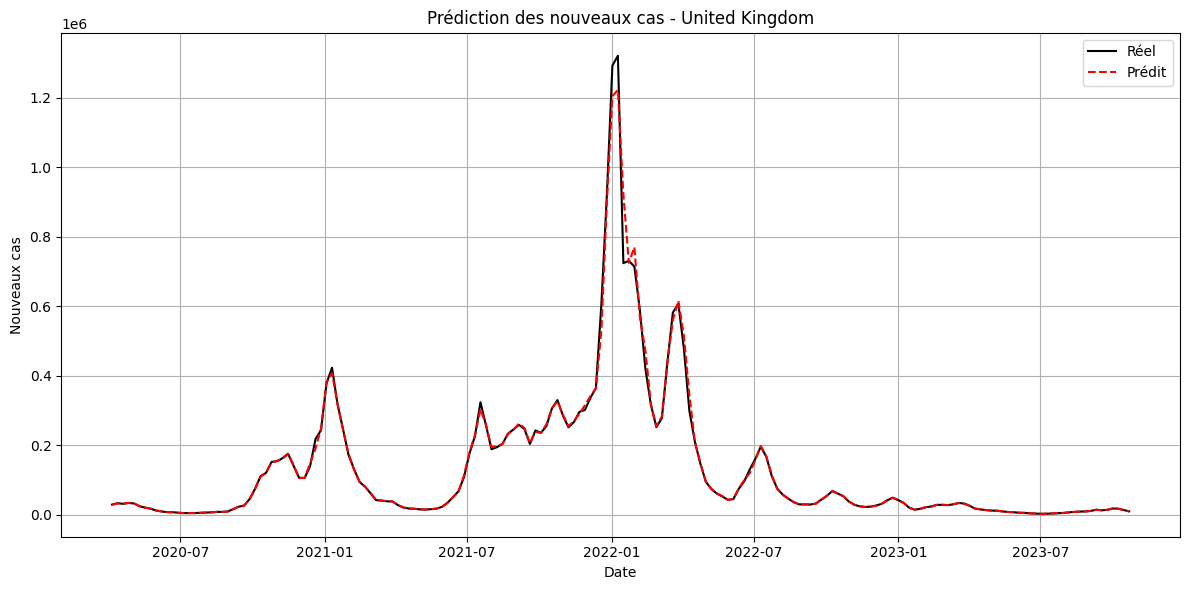

In [71]:
example_country = "United Kingdom"
df_test = df.loc[X_test.index].copy()
df_test["y_pred"] = y_pred

df_test_country = df_test[df_test["country"] == example_country]

plt.figure(figsize=(12, 6))
plt.plot(df_test_country["date"], df_test_country["new_cases"], label="Réel", color='black')
plt.plot(df_test_country["date"], df_test_country["y_pred"], label="Prédit", color='red', linestyle='--')
plt.title(f"Prédiction des nouveaux cas - {example_country}")
plt.xlabel("Date")
plt.ylabel("Nouveaux cas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

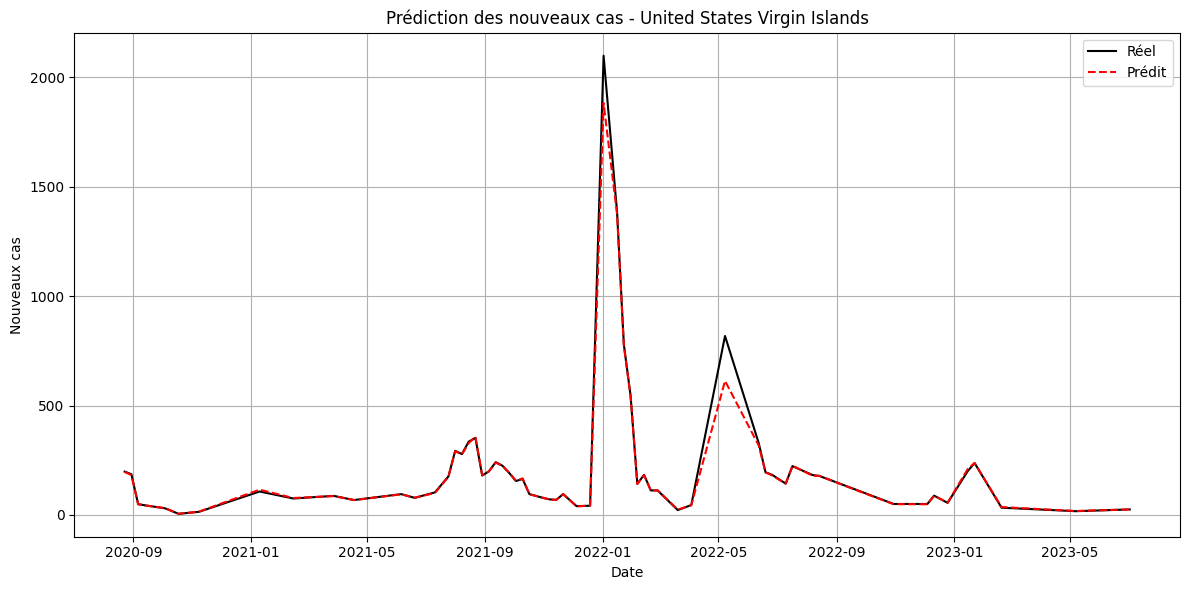

In [69]:
example_country = "United States Virgin Islands"
df_test = df.loc[X_test.index].copy()
df_test["y_pred"] = y_pred

df_test_country = df_test[df_test["country"] == example_country]

plt.figure(figsize=(12, 6))
plt.plot(df_test_country["date"], df_test_country["new_cases"], label="Réel", color='black')
plt.plot(df_test_country["date"], df_test_country["y_pred"], label="Prédit", color='red', linestyle='--')
plt.title(f"Prédiction des nouveaux cas - {example_country}")
plt.xlabel("Date")
plt.ylabel("Nouveaux cas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

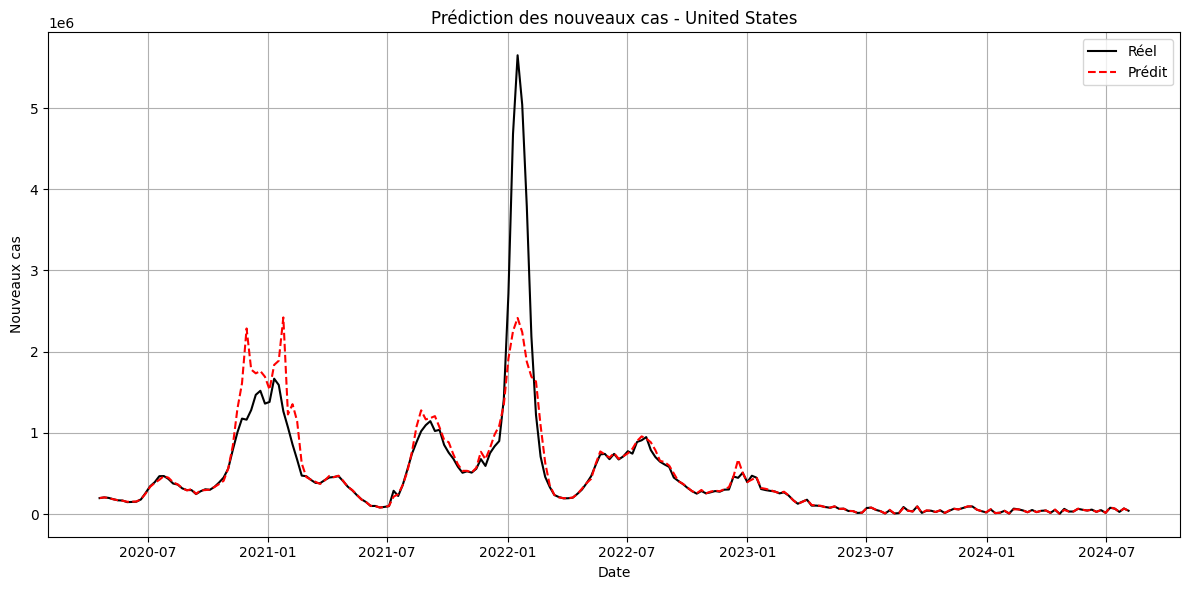

In [70]:
example_country = "United States"
df_test = df.loc[X_test.index].copy()
df_test["y_pred"] = y_pred

df_test_country = df_test[df_test["country"] == example_country]

plt.figure(figsize=(12, 6))
plt.plot(df_test_country["date"], df_test_country["new_cases"], label="Réel", color='black')
plt.plot(df_test_country["date"], df_test_country["y_pred"], label="Prédit", color='red', linestyle='--')
plt.title(f"Prédiction des nouveaux cas - {example_country}")
plt.xlabel("Date")
plt.ylabel("Nouveaux cas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Évaluation du Modèle – Random Forest Global

Ce modèle global a pour but de **prédire le nombre de nouveaux cas COVID-19 pour tous les pays**, à partir de variables épidémiques et politiques historiques, sans tenir compte explicitement du pays (pas de feature `country`).

---

### Résultats globaux (test set)

| Métrique                           | Valeur       |
|-----------------------------------|--------------|
| MAE (Mean Absolute Error)         | 6 840.29     |
| RMSE (Root Mean Squared Error)    | 88 702.77    |
| R² (Coefficient de détermination) | 0.83         |

---

### Interprétation

- **MAE ≈ 6 840** : en moyenne, le modèle se trompe de ~6 840 cas par jour pour un pays donné.
- **RMSE ≈ 88 703** : les grosses erreurs sont fortement pénalisées ; cela reflète les pics violents mal captés.
- **R² = 0.83** : le modèle explique **83 % de la variance globale** des nouveaux cas.

---

### 🔎 Analyse par courbes

- Pour certains pays comme **United Kingdom**, **United States Virgin Islands** ou **United States**, le modèle suit bien la tendance globale.
- Cependant, **lors de pics épidémiques violents**, le modèle tend à :
  - sous-estimer l’ampleur réelle,
  - lisser la variation c'est-à-dire qu'il ne capture pas les pics aigus,
  - réagir avec un léger **retard temporel**.

Ces effets sont visibles sur les courbes réelles vs prédites.

---

### Limites observées

- Les **ruptures brutales**, causées par des facteurs exogènes (variants, changements politiques, etc.) sont difficilement capturables sans **données contextuelles supplémentaires**.
- Le modèle **n’étant pas séquentiel**, il ne capture pas toujours les transitions rapides ou événements ponctuels.

---

###  Pistes d’amélioration possibles

- Enrichir le modèle avec des **données externes** : mobilité, météo, restrictions sanitaires détaillées.
- Tester des modèles **séquentiels** comme les LSTM (RNN).
- Ajouter un module de **détection de pics** ou d’anomalies.


In [77]:
# Sauvegarde
import joblib
joblib.dump(model, "../model/rf_model_global.joblib")

['../model/rf_model_global.joblib']